### bd CPS graph basic labor market indicators

bd_CPS_grapher.ipynb

October 1, 2018

@bd_econ

Requires: `cpsYYYY.ft`.

____

Notes:

Several [open issues](https://github.com/bdecon/econ_data/issues) on GitHub. This code needs to do four things: 1) read and aggregate CPS data as instructed (one month, three months, one year, two years); 2) Apply some pre-specified calculations, such as the employment-to-population ratio, unemployment rate, usual earnings at various percentiles, etc.; 3) apply adjustments after the fact, such as moving average, or adjustment for inflation; and 4) allow for collecting data on multiple groups during each read cycle. 

Once the collected data are prepared, use matplotlib to generate nice-looking line plots. 



The [categorization](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of those not in the labor force is provided by the Federal Reserve Bank of Atlanta. 

In [1]:
# Import packages, adjust settings and set file path
import os
import pandas as pd
import numpy as np
import wquantiles

os.chdir('/home/brian/Documents/CPS/data/clean/')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'axes.titlesize': 'x-large'})

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

# Years of bd CPS data
year_range = range(1994, 2019)   

In [2]:
# Define functions to collect and graph data
def bd_cps_data(query_str, calc_type, smoothing='12sma'):
    """Calculate various labor market indicators from
       bd CPS annual feather files."""
    
    #Default columns to keep in initial data read
    filter_cols = ['PREMPNOT', 'PWSSWGT', 'HRMONTH']
    keep_cols = []
    
    # Employment-to-population ratio
    if calc_type == 'epop':
        keep_cols = ['EMP', 'POP', 'HRMONTH']
        component_vars = {'EMP': lambda x: np.where(x['PREMPNOT']==1,  x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['EMP'] / x['POP'])

    # Unemployment rate
    if calc_type == 'unrate':
        keep_cols = ['UNEMP', 'LF', 'HRMONTH']
        component_vars = {'UNEMP': lambda x: np.where(x['PREMPNOT']==2, x['PWSSWGT'], 0),
                          'LF': lambda x: np.where(x['PREMPNOT'].isin([1, 2]), x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['UNEMP'] / x['LF'])
    
    # Labor force participation rate
    if calc_type == 'lfpr':
        keep_cols = ['LF', 'POP', 'HRMONTH']
        component_vars = {'LF': lambda x: np.where(x['PREMPNOT'].isin([1, 2]), x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['LF'] / x['POP'])
        
    # Population in levels (works on age 16+)
    if calc_type == 'pop':
        keep_cols = ['POP', 'HRMONTH']        
        component_vars = {'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: x['POP'] / 12
        
    # Labor union membership (or similar, such as employee association)
    if calc_type == 'union':
        filter_cols = ['PEERNLAB', 'PWORWGT', 'HRMONTH']
        keep_cols = ['UNION', 'TOT', 'HRMONTH']
        component_vars = {'TOT': lambda x: np.where(x['PEERNLAB'].isin([1, 2]), x['PWORWGT'], 0),
                          'UNION': lambda x: np.where(x['PEERNLAB']==1, x['PWORWGT'], 0)}
        calc_var = lambda x: (x['UNION'] / x['TOT'])
        
    # Not in the labor force because of disability or illness
    if calc_type == 'nilf_disill':
        filter_cols = ['PRWNTJOB', 'PEMLR', 'PREMPNOT', 'PENLFACT', 'PWSSWGT', 'HRMONTH']
        keep_cols = ['DISILL', 'POP', 'HRMONTH']
        component_vars = {'DISILL': lambda x: np.where(((x['PRWNTJOB']==2) & 
                                                        ((x['PEMLR']==6) | 
                                                         (x['PENLFACT']==1) | 
                                                         (x['PENLFACT']==2))), x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['DISILL'] / x['POP'])
        
    # NILF - school
    if calc_type == 'nilf_school':
        filter_cols = ['PRWNTJOB', 'PREMPNOT', 'PENLFACT', 'PWSSWGT', 'HRMONTH']
        keep_cols = ['SCHOOL', 'POP', 'HRMONTH']
        component_vars = {'SCHOOL': lambda x: np.where((x['PRWNTJOB']==2) & (x['PENLFACT']==3), 
                                                       x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['SCHOOL'] / x['POP']) 
        
    # NILF - caring for home or others
    if calc_type == 'nilf_care':
        filter_cols = ['PRWNTJOB', 'PREMPNOT', 'PENLFACT', 'PWSSWGT', 'HRMONTH']
        keep_cols = ['CARE', 'POP', 'HRMONTH']
        component_vars = {'CARE': lambda x: np.where((x['PRWNTJOB']==2) & (x['PENLFACT']==4), 
                                                       x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['CARE'] / x['POP'])      
        
    # NILF - retired
    if calc_type == 'nilf_retired':
        filter_cols = ['PRWNTJOB', 'PEMLR', 'PREMPNOT', 'PENLFACT', 'PWSSWGT', 'HRMONTH']
        keep_cols = ['RETIRED', 'POP', 'HRMONTH']
        component_vars = {'RETIRED': lambda x: np.where(((x['PRWNTJOB']==2) & 
                                                     ((x['PEMLR']==5) | 
                                                      (x['PENLFACT']==5))), 
                                                       x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['RETIRED'] / x['POP'])         
        
    # NILF - discourged
    if calc_type == 'nilf_discouraged':
        filter_cols = ['PEDWWNTO', 'PREMPNOT', 'PWSSWGT', 'HRMONTH']
        keep_cols = ['DISCOURAGED', 'POP', 'HRMONTH']
        component_vars = {'DISCOURAGED': lambda x: np.where(x['PEDWWNTO']==1,
                                                           x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['DISCOURAGED'] / x['POP'])       
    
    if len(keep_cols) > 0:
        data = (pd.concat(
            [(pd.read_feather(f'cps{year}.ft', nthreads=3)
                .query(query_str)
                .filter(items = filter_cols)
                .assign(**component_vars)
                .filter(items = keep_cols)
                .groupby('HRMONTH').sum()
                .pipe(cps_datetime, year)
                .set_index('DATE')) 
            for year in year_range])
                .rolling(12).sum().dropna()
                .assign(FINAL = calc_var)
               )['FINAL']
    
    # Usual hourly earnings - real, at the median
    if calc_type == 'median_hourly_wage_real':
        filter_cols = ['RHRWAGE', 'PWORWGT', 'HRMONTH']
        wage_var = 'RHRWAGE'
    # Usual weekly earnings - real, at the median
    if calc_type == 'median_weekly_wage_real':
        filter_cols = ['RWKWAGE', 'PWORWGT', 'HRMONTH']
        wage_var = 'RWKWAGE'
        
    if 'wage' in calc_type:
        data = (pd.concat(
            [(pd.read_feather(f'cps{year}.ft', nthreads=3)
                .query(query_str)
                .filter(items = filter_cols)
                .rename({wage_var: 'WAGE'}, axis=1)
                .groupby('HRMONTH').apply(binned_median)
                .reset_index().set_index('HRMONTH')
                .pipe(cps_datetime, year)
                .set_index('DATE'))
            for year in year_range])
                .rolling(12).mean().dropna()
               )[0]

    return data

def binned_median(dfm):
    """Return BLS-styled binned median wage"""
    if dfm['WAGE'].max() < 200:
        wage_ranges = list(np.arange(0.125,200,0.25))
    else:
        wage_ranges = list(np.arange(2.5,3000,5.0))        
    dft = (dfm.query('WAGE > 0')
              .sort_values('WAGE')
              .assign(WAGE_RANGE = (lambda x: pd.cut(x['WAGE'], wage_ranges, 
                                           include_lowest=True)),
                      CS = lambda x: x['PWORWGT'].cumsum()))
    
    midpt = dft['PWORWGT'].sum() * 0.5
    mid_interval = dft.iloc[(dft['CS']-midpt).abs().argsort()[:1]].WAGE_RANGE.values[0]

    wage_bins = list(dft['WAGE_RANGE'].unique())

    mi_loc = wage_bins.index(mid_interval)
    lowval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc-1]].iloc[-1].CS
    highval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc]].iloc[-1].CS

    binned_med = ((((midpt - lowval) / (highval - lowval)) * 0.5) + mid_interval.left)
    
    return(binned_med)


def cps_datetime(df, year):
    """Return DATE '1994-01-01' from HRMONTH and year"""
    df['DATE'] = [pd.to_datetime(f'{year}-{month}-01') 
                  for month in df.index]
    return df 
    

def labor_mkt_grapher(title, data, color):
    """Graph time series data from 1994 to present, with recession bars
       and the most recent monthly data point labeled and annotated."""
    if data.max() <= 1.0:
        ftype = 'pct'
    elif data.max() <= 2000.0:
        ftype = 'usd'
    else:
        ftype = 'people'
    if ftype == 'pct':
        data = data * 100.0
    spcr, spcr2 = (data.max() - data.min()) / 26, (data.max() - data.min()) / 40
    ax = data.plot(figsize=(8, 4), color=color)
    ax = plt.title(title, loc='left')
    ax = plt.scatter([data.index[-1]], [data[-1]], color=color, s=25)
    for i, v in rec_dt:
        ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)
    if ftype == 'pct':
        ax = plt.annotate(f'   {data[-1]: .1f}%', (data.index[-1], data[-1]-spcr2))
    elif ftype == 'usd':
        ax = plt.annotate(f'   ${data[-1]: .2f}', (data.index[-1], data[-1]-spcr2))
    else:
        ax = plt.annotate(f'   {int(data[-1]):,}', (data.index[-1], data[-1]-spcr2))        
    ax = plt.xlabel('Source: Current Population Survey microdata, 12-month moving average', ha='left', x=0)
    ax = plt.annotate(f'  {data.index[-1]:%b %Y}', (data.index[-1], data[-1]+spcr), 
                      fontweight='bold')

In [5]:
# Example query string used to filter CPS
filters = 'AGE >= 25 and AGE <= 54 and FEMALE == 1'
group = 'women age 25-54'
#filters = 'STATE=="NY"'
#filters = 'WBHAO=="Black" and AGE < 25 and FEMALE == 0'
#filters = 'FEMALE == 1 and MARRIED == 1'
#group = 'married women'

In [8]:
filters = 'INDGRP == "Manufacturing"'
group = 'manufacturing industries'

In [3]:
filters = 'FORBORN == 1'
group = 'foreign born'

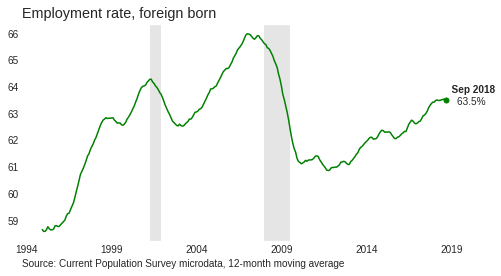

In [4]:
# Employment Rate
calc_type = 'epop'
title = f'Employment rate, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

In [ ]:
# Unemployment Rate
calc_type = 'unrate'
title = f'Unemployment rate, {group}'
data = bd_cps_data(filters, calc_type) 
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Labor force participation Rate
calc_type = 'lfpr'
title = f'Labor force participation rate, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

In [ ]:
# Union membership rate (uses 1/4 sample)
calc_type = 'union'
title = f'Union membership rate, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'orange')

In [ ]:
# Population estimate (12 month moving average)
calc_type = 'pop'
title = f'Population, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'purple')

In [ ]:
# Not in the labor force because of illness or disability
calc_type = 'nilf_disill'
title = f'Not in the labor force, disability or illness, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Not in the labor force because of school
calc_type = 'nilf_school'
title = f'Not in the labor force, in school, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

In [ ]:
# Not in the labor force because of care role
calc_type = 'nilf_care'
title = f'Not in the labor force, care role, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

In [ ]:
# Not in the labor force because of retirement
calc_type = 'nilf_retired'
title = f'Not in the labor force, retired, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'orange')

In [ ]:
# Not in the labor force because of discouraged
calc_type = 'nilf_discouraged'
title = f'Not in the labor force, discouraged, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'purple')

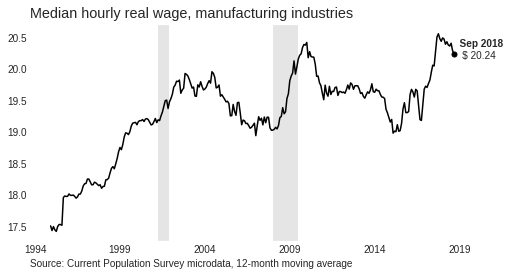

In [9]:
# Median hourly wage, nominal
calc_type = 'median_hourly_wage_real'
title = f'Median hourly real wage, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'black')

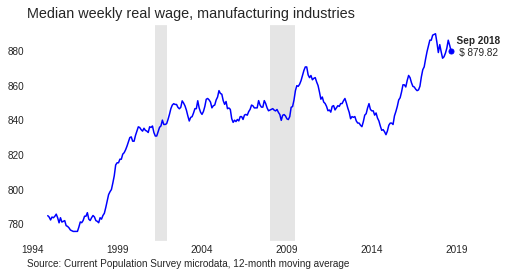

In [10]:
# Median hourly wage, nominal
calc_type = 'median_weekly_wage_real'
title = f'Median weekly real wage, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')